In [5]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn

In [6]:
batch_size = 64
train_trans = transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.525, 0.469, 0.578), (0.497, 0.532, 0.487))
])
test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.525, 0.469, 0.578), (0.497, 0.532, 0.487))
])
train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_trans)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pooling = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 128)
        self.fc3 = torch.nn.Linear(128, 10)
        self.drop1 = torch.nn.Dropout2d(0.4)
        self.drop2 = torch.nn.Dropout2d(0.2)
        self.drop3 = torch.nn.Dropout2d(0.1)

    def forward(self, x):
        # print("shape0:", x.shape)
        x = torch.relu(self.pooling(self.conv1(x)))
        x = self.bn1(x)
        # x = self.drop3(x)
        # print("shape1:", x.shape)
        x = torch.relu(self.pooling(self.conv2(x)))
        x = self.bn2(x)
        # x = self.drop2(x)
        # print("shape2:", x.shape)
        x = torch.relu(self.pooling(self.conv3(x)))
        # x = self.drop3(x)
        x = self.bn3(x)
        x = x.view(x.size(0), -1)
        # print("shape v:", x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # print("shape-:", x.shape)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --0----------------------
# model = Net()

# --1----------------------
model = models.resnet50(pretrained=True)
fc_features = model.fc.in_features
model.fc = nn.Linear(fc_features, 10)

# --2----------------------
# model = models.vgg19(pretrained=True)

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0000000001)

D:\Mysoftware_setup\anaconda3\envs\mypytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Mysoftware_setup\anaconda3\envs\mypytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
def train(epoch):
    running_loss = 0.0
    for idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optim.step()
        running_loss += loss.item()
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, idx + 1, running_loss / 100))
            running_loss = 0.0


def test(epoch):
    correct = 0
    total = 0
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        # print("outputs shape", outputs.shape)
        # print("predicted shape", predicted.shape)
        # print("labels shape", labels.shape)
        correct_tensor = predicted.eq(labels.data.view_as(predicted))
        correct += correct_tensor.sum().item()
        total += labels.size(0)
    print('epoch: %d accuracy on test set: %d %% ' % (epoch + 1, 100 * correct / total))
    return correct / total

[1,   100] loss: 1.482
[1,   200] loss: 1.140
[1,   300] loss: 1.037
[1,   400] loss: 0.998
[1,   500] loss: 0.929
[1,   600] loss: 0.911
[1,   700] loss: 0.819
epoch: 1 accuracy on test set: 73 % 
[2,   100] loss: 0.687
[2,   200] loss: 0.729
[2,   300] loss: 0.761
[2,   400] loss: 0.693
[2,   500] loss: 0.681
[2,   600] loss: 0.769
[2,   700] loss: 1.335
epoch: 2 accuracy on test set: 67 % 
[3,   100] loss: 0.840
[3,   200] loss: 0.755
[3,   300] loss: 0.720
[3,   400] loss: 0.673
[3,   500] loss: 0.670
[3,   600] loss: 0.623
[3,   700] loss: 0.628
epoch: 3 accuracy on test set: 79 % 
[4,   100] loss: 0.504
[4,   200] loss: 0.535
[4,   300] loss: 0.540
[4,   400] loss: 0.546
[4,   500] loss: 0.542
[4,   600] loss: 0.525
[4,   700] loss: 0.526
epoch: 4 accuracy on test set: 81 % 
[5,   100] loss: 0.652
[5,   200] loss: 0.902
[5,   300] loss: 0.943
[5,   400] loss: 0.750
[5,   500] loss: 0.592
[5,   600] loss: 0.554
[5,   700] loss: 0.544
epoch: 5 accuracy on test set: 77 % 
[6,   100]

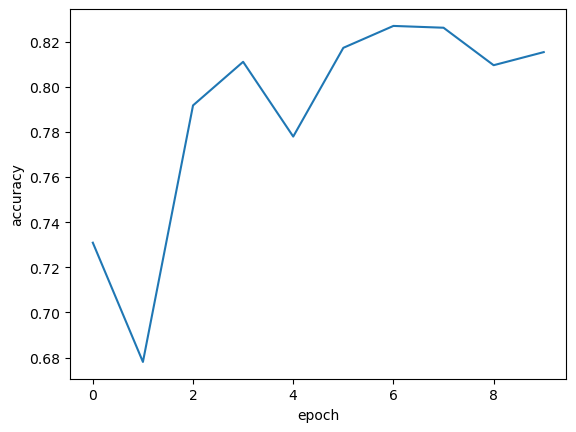

In [10]:
epoch_list = []
acc_list = []
model.train()
for epoch in range(10):
    model.train()
    train(epoch)
    model.eval()
    acc = test(epoch)
    epoch_list.append(epoch)
    acc_list.append(acc)
print(f"average: {sum(acc_list) / len(acc_list)} %")
plt.plot(epoch_list, acc_list)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()